#### Cell 1 — Root & imports

In [1]:
from pathlib import Path
import sys
root = Path("..").resolve()
sys.path.append(str(root / "src"))
print("root:", root)


root: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL


### Cell 2 — Load manifest & basic params

In [2]:
import pandas as pd, json, yaml
from collections import Counter

CFG = yaml.safe_load(open(root / "configs" / "wlasl100.yaml"))
MANIFEST = root / "data" / "metadata" / "wlasl100_manifest.csv"
m = pd.read_csv(MANIFEST)

print("Total clips:", len(m))
print("By split:\n", m.groupby("split").size())
print("Classes:", m["label"].nunique())


Total clips: 752
By split:
 split
test      81
train    547
val      124
dtype: int64
Classes: 100


### Cell 3 — Dataset (pure PyTorch + decord, no torchvision)

In [3]:
import torch, numpy as np, cv2, decord, random
from torch.utils.data import Dataset, DataLoader

decord.bridge.set_bridge("torch")

def _resize_112(frame_tchw: torch.Tensor) -> torch.Tensor:
    # frame_tchw: [T,C,H,W] float32 [0,1]
    T,C,H,W = frame_tchw.shape
    # Use OpenCV for speed; convert to NHWC
    arr = frame_tchw.permute(0,2,3,1).cpu().numpy()  # T,H,W,C
    out = np.empty((T,112,112,C), dtype=np.float32)
    for t in range(T):
        out[t] = cv2.resize(arr[t], (112,112), interpolation=cv2.INTER_AREA)
    out = torch.from_numpy(out).permute(0,3,1,2)  # T,C,112,112
    return out

def _normalize(frame_tchw: torch.Tensor, mean=(0.45,0.45,0.45), std=(0.225,0.225,0.225)) -> torch.Tensor:
    # per-channel normalization
    mean = torch.tensor(mean, dtype=frame_tchw.dtype, device=frame_tchw.device)[None,:,None,None]
    std  = torch.tensor(std,  dtype=frame_tchw.dtype, device=frame_tchw.device)[None,:,None,None]
    return (frame_tchw - mean) / std

def uniform_temporal_indices(n_total, clip_len, stride):
    # Aim to cover as much as possible; for short videos, loop-pad
    if n_total <= 0: return [0]*clip_len
    wanted = (clip_len-1)*stride + 1
    if n_total >= wanted:
        # center-start for consistent coverage
        start = (n_total - wanted)//2
        return [start + i*stride for i in range(clip_len)]
    # not enough frames: repeat last index
    idxs = [min(i*stride, n_total-1) for i in range(clip_len)]
    return idxs

class WLASLDataset(Dataset):
    def __init__(self, df: pd.DataFrame, clip_len=32, stride=2, train=False):
        self.df = df.reset_index(drop=True)
        self.clip_len = clip_len
        self.stride = stride
        self.train = train

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        path = row["path"]
        label = int(row["label"])
        vr = decord.VideoReader(path)
        n = len(vr)

        idxs = uniform_temporal_indices(n, self.clip_len, self.stride)
        batch = vr.get_batch(idxs)  # [T,H,W,C] uint8
        # to float [0,1], TCHW
        x = batch.float()/255.0
        x = x.permute(0,3,1,2)
        # spatial resize 112x112
        x = _resize_112(x)
        # normalize
        x = _normalize(x)
        return x, label, path


#### Cell 4 — Build loaders (with WeightedRandomSampler for train)

In [4]:
from torch.utils.data import WeightedRandomSampler

train_df = m[m["split"]=="train"].copy()
val_df   = m[m["split"]=="val"].copy()
test_df  = m[m["split"]=="test"].copy()

clip_len   = 32
frame_step = 2

# class weights ∝ 1/freq
counts = train_df["label"].value_counts().to_dict()
weights = train_df["label"].map(lambda y: 1.0/max(1, counts[y])).values
sampler = WeightedRandomSampler(torch.tensor(weights, dtype=torch.double),
                                num_samples=len(train_df), replacement=True)

train_ds = WLASLDataset(train_df, clip_len, frame_step, train=True)
val_ds   = WLASLDataset(val_df,   clip_len, frame_step, train=False)
test_ds  = WLASLDataset(test_df,  clip_len, frame_step, train=False)

train_loader = DataLoader(train_ds, batch_size=CFG["train"]["batch_size"], sampler=sampler,
                          num_workers=CFG["train"]["num_workers"], pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=CFG["train"]["batch_size"], shuffle=False,
                          num_workers=CFG["train"]["num_workers"], pin_memory=True)


### Cell 5 — Visual sanity check (grid of frames)

clip: torch.Size([32, 3, 112, 112]) label: 29 path: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/data/videos/train/thanksgiving/57638.mp4


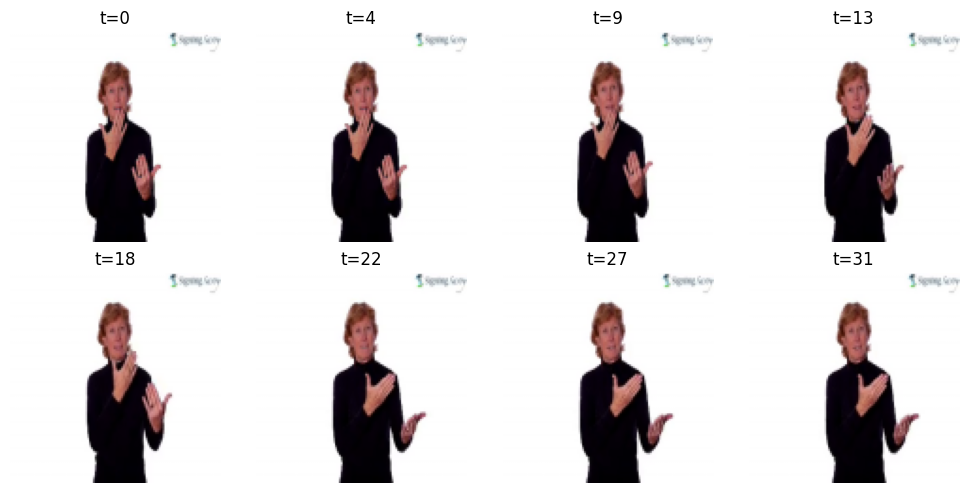

In [5]:
import matplotlib.pyplot as plt

x, y, p = train_ds[0]
print("clip:", x.shape, "label:", y, "path:", p)

# show 8 frames
sel = torch.linspace(0, x.shape[0]-1, steps=8).round().long().tolist()
fig, axes = plt.subplots(2,4, figsize=(10,5))
for ax, t in zip(axes.flatten(), sel):
    img = x[t].permute(1,2,0).cpu()
    # denormalize for display
    img = (img * torch.tensor([0.225,0.225,0.225])) + torch.tensor([0.45,0.45,0.45])
    img = img.clamp(0,1).numpy()
    ax.imshow(img)
    ax.set_title(f"t={t}")
    ax.axis("off")
plt.tight_layout(); plt.show()
